# Predict Stock Price

1. Get historic stock price data
2. Extract price to predict
3. Normalize
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [2]:
from tensorflow.keras import backend as K
import os
from importlib import reload

def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")
#set_keras_backend("cntk")

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import Sequential
#from sklearn.cross_validation import  train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math

In [6]:
np.random.seed(7)

In [8]:
#load the dataset
url = 'https://raw.githubusercontent.com/maochaokuo/tensorflow1/master/sharedfiles/HistoricalQuotes.csv'
msft_dataset = pd.read_csv(url) #'~/HistoricalQuotes.csv')
msft_dataset.head()

,dealdate,dealtime,dealdatetime,open,high,low,close,volume
0,20180629,84500,2018-06-29 08:45:00,10541.0,10542.0,10529.0,10531.0,4426
1,20180629,84600,2018-06-29 08:46:00,10531.0,10532.0,10526.0,10531.0,2142
2,20180629,84700,2018-06-29 08:47:00,10530.0,10532.0,10530.0,10532.0,454
3,20180629,84800,2018-06-29 08:48:00,10531.0,10538.0,10529.0,10536.0,1204
4,20180629,84900,2018-06-29 08:49:00,10537.0,10537.0,10527.0,10527.0,1522


In [9]:
msft_dataset.dtypes

dealdate          int64
dealtime          int64
dealdatetime     object
open            float64
high            float64
low             float64
close           float64
volume            int64
dtype: object

In [10]:
msft_dataset['date'] = pd.to_datetime(msft_dataset['dealdatetime'])
msft_dataset['close'] = pd.to_numeric(msft_dataset['close'], downcast='float')

In [11]:
msft_dataset.set_index('date',inplace=True)
msft_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48224 entries, 2018-06-29 08:45:00 to 2019-02-22 13:44:00
Data columns (total 8 columns):
dealdate        48224 non-null int64
dealtime        48224 non-null int64
dealdatetime    48224 non-null object
open            48224 non-null float64
high            48224 non-null float64
low             48224 non-null float64
close           48224 non-null float32
volume          48224 non-null int64
dtypes: float32(1), float64(3), int64(3), object(1)
memory usage: 3.1+ MB


In [12]:
msft_dataset.sort_index(inplace=True)

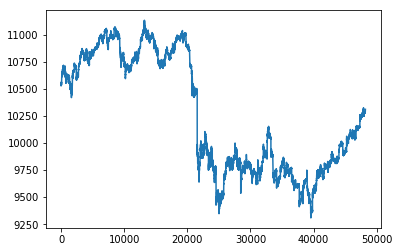

In [13]:
#extract just close prices as that is what we want to predict
msft_close = msft_dataset['close']
msft_close = msft_close.values.reshape(len(msft_close), 1)
plt.plot(msft_close)
plt.show()

In [14]:
#normalize data
scaler = MinMaxScaler(feature_range=(0,1)) # ??

In [15]:
msft_close = scaler.fit_transform(msft_close) # ??
msft_close

array([[0.67050457],
       [0.67050457],
       [0.67105246],
       ...,
       [0.54605246],
       [0.5471492 ],
       [0.54934216]], dtype=float32)

In [16]:
#split data into train and test
train_size = int(len(msft_close)* 0.7)
test_size = len(msft_close) - train_size

msft_train, msft_test = msft_close[0:train_size, :], msft_close[train_size:len(msft_close), :] #??很奇怪的寫法

print('Split data into train and test: ', len(msft_train), len(msft_test))

Split data into train and test:  33756 14468


In [17]:
#need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price

def create_ts(ds, series):#?? 
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)# ?? np

series = 7

trainX, trainY = create_ts(msft_train, series)
testX, testY = create_ts(msft_test, series)

In [18]:
trainX

array([[0.67050457, 0.67050457, 0.67105246, ..., 0.6683116 , 0.67050457,
        0.67105246],
       [0.67050457, 0.67105246, 0.67324543, ..., 0.67050457, 0.67105246,
        0.6699562 ],
       [0.67105246, 0.67324543, 0.6683116 , ..., 0.67105246, 0.6699562 ,
        0.6688595 ],
       ...,
       [0.19078922, 0.19024134, 0.19078922, ..., 0.18914461, 0.18969297,
        0.18969297],
       [0.19024134, 0.19078922, 0.18914461, ..., 0.18969297, 0.18969297,
        0.18914461],
       [0.19078922, 0.18914461, 0.18914461, ..., 0.18969297, 0.18914461,
        0.19024134]], dtype=float32)

In [19]:
trainX[0]

array([0.67050457, 0.67050457, 0.67105246, 0.67324543, 0.6683116 ,
       0.67050457, 0.67105246], dtype=float32)

In [20]:
#reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))#??
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [21]:
#build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#fit the model
model.fit(trainX, trainY, epochs=100, batch_size=32)#??batch_size

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
33748/33748 [==============================] - 10s 285us/sample - loss: 0.0107
Epoch 2/100
33748/33748 [==============================] - 4s 125us/sample - loss: 1.1424e-04
Epoch 3/100
33748/33748 [==============================] - 4s 121us/sample - loss: 5.7499e-05
Epoch 4/100
33748/33748 [==============================] - 4s 129us/sample - loss: 4.6339e-05
Epoch 5/100
33748/33748 [==============================] - 4s 121us/sample - loss: 3.7633e-05
Epoch 6/100
33748/33748 [==============================] - 4s 131us/sample - loss: 2.9552e-05
Epoch 7/100
33748/33748 [==============================] - 4s 132us/sample - loss: 2.5772e-05
Epoch 8/100
33748/33748 [==============================] - 4s 132us/sample - loss: 2.4519e-05
Epoch 9/100
33748/33748 [==============================] - 4s 130us/sample - loss: 

33748/33748 [==============================] - 4s 120us/sample - loss: 1.2179e-05
Epoch 80/100
33748/33748 [==============================] - 4s 128us/sample - loss: 1.2164e-05
Epoch 81/100
33748/33748 [==============================] - 4s 127us/sample - loss: 1.2031e-05
Epoch 82/100
33748/33748 [==============================] - 4s 126us/sample - loss: 1.2102e-05
Epoch 83/100
33748/33748 [==============================] - 4s 127us/sample - loss: 1.1938e-05
Epoch 84/100
33748/33748 [==============================] - 4s 124us/sample - loss: 1.1979e-05
Epoch 85/100
33748/33748 [==============================] - 4s 119us/sample - loss: 1.2125e-05
Epoch 86/100
33748/33748 [==============================] - 4s 118us/sample - loss: 1.2159e-05
Epoch 87/100
33748/33748 [==============================] - 4s 122us/sample - loss: 1.2035e-05
Epoch 88/100
33748/33748 [==============================] - 4s 120us/sample - loss: 1.1995e-05
Epoch 89/100
33748/33748 [==============================] - 4s 

In [22]:
#test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)
#unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)#??scaler
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [23]:
#lets calculate the root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))#??
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)

Train score: %.2f rmse 6.189068727172461
Test score: %.2f rmse 5.26887354878282


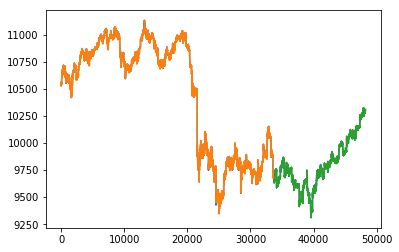

In [24]:
#lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(msft_close)#??
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(msft_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(msft_close)-1, :] = testPredictions

#plot on graph
plt.plot(scaler.inverse_transform(msft_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()